<a href="https://colab.research.google.com/github/Peienn/DRL/blob/main/2_L14_2_dqn_implement_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

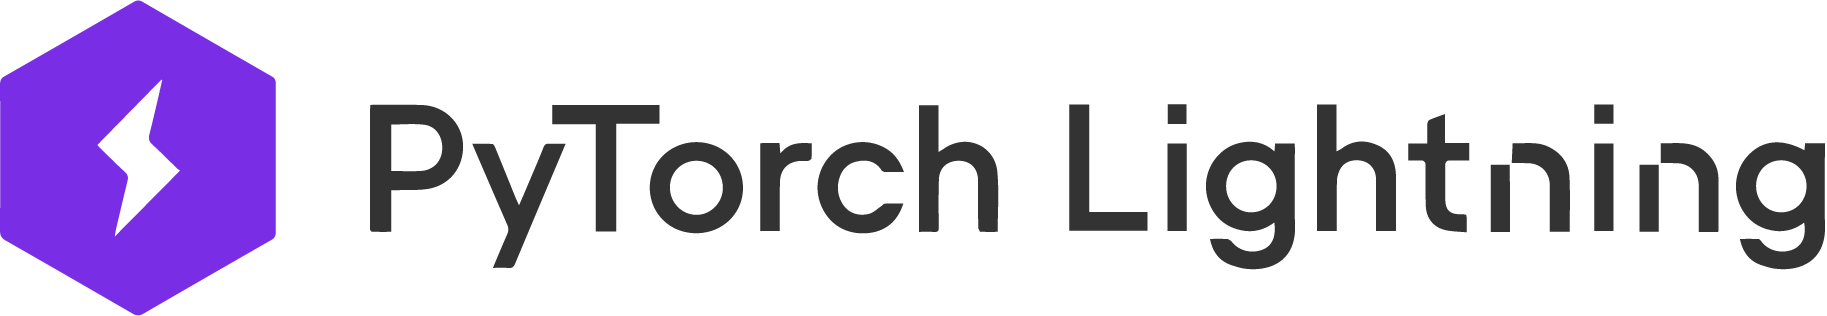

###改善的的安裝方式

In [1]:
!apt-get install  -y xvfb

!pip install  gym==0.21 gym[box2d] pytorch-lightning==1.6.0 pyvirtualdisplay
# !pip install  https://github.com/PyTorchLightning/pytorch-lightning/archive/refs/heads/release/1.5.x.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (783 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

###下面是原來的安裝方式

In [2]:

# !apt-get install -y xvfb
# !pip install \
#   gym==0.21 \
#   gym[box2d] \
#   pyvirtualdisplay
# !pip install git+https://github.com/PyTorchLightning/pytorch-lightning

#### Setup virtual display

In [3]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [4]:
import copy
import gym
import torch

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule,Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [5]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [6]:
class DQN(nn.Module):

  def __init__(self,hidden_size, obs_size, n_actions):
      super().__init__()
      self.net=nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
      )
  
  def forward(self,x):
    return self.net(x.float())


  

#### Create the policy

In [27]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action =torch.max(q_values, dim=1)
    action = int(action.item())
  return action

#### Create the replay buffer

In [8]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer= deque(maxlen=capacity)
  
  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience) 

  def sample(self,batch_size):
    return random.sample(self.buffer,batch_size) 

In [9]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
     self.buffer = buffer
     self.sample_size = sample_size
    
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment

In [24]:
def create_environment(name='CartPole-v0'):
 env=gym.make(name)
 #print(env.observation_space.sample())
 #print(env.action_space.sample())
 return env 

#### Create the test/sampling function

[ 1.9789486e+00 -1.7711568e+38  2.3520878e-01 -2.9735507e+38]
1


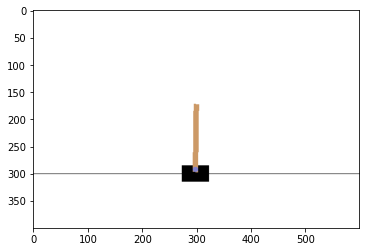

In [25]:
#test environment
env=create_environment('CartPole-v0')
state=env.reset()
action=env.action_space.sample()

next_state, re, done, debug =env.step(action)

import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'))


[ 2.8425541e+00 -2.0658944e+38 -5.1016267e-02  6.2332413e+37]
1


#### Create the Deep Q-Learning algorithm

In [28]:
class DeepQLearning(LightningModule):

  #initialize
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000, batch_size=256,lr=1e-3, 
          hidden_size=128,gamma=0.99,loss_fn=F.smooth_l1_loss, optim=AdamW, 
          eps_start=1.0,eps_end=0.15,eps_last_episode=100,samples_per_epoch=10_000,sync_rate=10):
    
    super().__init__()
    self.env=create_environment(env_name)

    obs_size= self.env.observation_space.shape[0]
    n_actions=self.env.action_space.n

    self.q_net=DQN(hidden_size,obs_size,n_actions)

    self.target_q_net= copy.deepcopy(self.q_net)

    self.policy =policy
    self.buffer=ReplayBuffer(capacity=capacity)
    self.save_hyperparameters()

    while len(self.buffer)<self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in expereience buffer. Filling ...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    state= self.env.reset()
    done=False
      
    while not done:
      if policy:
        action=policy(state, self.env, self.q_net,epsilon=epsilon)
      else:
        action=self.env.action_space.sample()
      
      next_state, reward, done, info=self.env.step(action)
      exp = (state, action, reward,done,next_state)
      self.buffer.append(exp)
      state=next_state

  #Forward path
  def forward(self, x):
    return self.q_net(x)

  #Config optimumizer
  def configure_optimizers(self):
    q_net_optimizer=self.hparams.optim(self.q_net.parameters(),lr=self.hparams.lr)
    return [q_net_optimizer]

  #prepare training state using data loader
  def train_dataloader(self):
    dataset=RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader=DataLoader(dataset=dataset,batch_size=self.hparams.batch_size)
    return dataloader

  # training step
  def training_step(self,batch,batch_idx):
    states, actions,rewards,dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones= dones.unsqueeze(1)
    #next_states = next_states.unsqueeze(1)

    state_action_values=self.q_net(states).gather(1, actions)
    next_action_values, _ =self.target_q_net(next_states).max(dim=1,keepdim=True)
    next_action_values[dones]= 0.0

    expected_state_action_values = rewards+ self.hparams.gamma*next_action_values
    loss=self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-Error',loss)
    return loss

  #training end 
  def training_epoch_end(self, training_step_outputs):

    epsilon= max(
      self.hparams.eps_end,
      self.hparams.eps_start-self.current_epoch/self.hparams.eps_last_episode
    )
    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate==0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())



#### Purge logs and run the visualization tool (Tensorboard)

In [12]:
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率


#### Train the policy

#### Check the resulting policy